In [185]:
import numpy as np
from qutip import *
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib
from math import factorial
from matplotlib import pyplot as plt
plt.rc('font', size=30)          # controls default text sizes
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels
plt.rc('legend', fontsize=30)    # legend fontsize
plt.rc('lines', markersize = 10)

matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 16, 10
plt.rcParams['figure.dpi'] = 70
matplotlib.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.which'] = "both"
props = dict(boxstyle='round', alpha=0.01)

In [186]:
def ham(J,K,h1,h2):
    sz = sigmaz()/2
    sx = sigmax()/2
    sy = sigmay()/2
    H = 0
    for ch in range(K):
        H += J*tensor([sx] + [identity(2)]*ch + [sx] + [identity(2)]*(K-ch-1))
        H += J*tensor([sy] + [identity(2)]*ch + [sy] + [identity(2)]*(K-ch-1))
        H += J*tensor([sz] + [identity(2)]*ch + [sz] + [identity(2)]*(K-ch-1))
        H += h2*tensor([identity(2)]*(1+ch) + [sz] + [identity(2)]*(K-ch-1))
    H += h1*tensor([sz] + [identity(2)]*K)
    return H

In [187]:
def get_Z(J,K,h1,h2,T):
    beta = 1/T
    H = ham(J,K,h1,h2)
    E = H.eigenenergies()
    Z = np.sum(np.exp(-beta*E))
    return Z

def get_chi_num(J,K,T_range):
    h2 = 0
    h1 = 0
    deltah = 0.00001
    chi = []
    for T in T_range:
        Z = get_Z(J,K,h1,h2,T)
        Z_plus_deltaZ = get_Z(J,K,h1+deltah,h2,T)
        Z_plus_2deltaZ = get_Z(J,K,h1+2*deltah,h2,T)
        dZdh = (Z_plus_deltaZ - Z)/deltah
        d2zdh2 = (Z_plus_2deltaZ + Z - 2*Z_plus_deltaZ)/(deltah**2)
        chi.append(T * (d2zdh2/Z - (dZdh/Z)**2))
        # print (Z, d2zdh2)
    return np.array(chi)

In [188]:
def get_chi_exact(J,K,T_range):
    M_max = K/2
    M_min = 0 if K%2 == 0 else 1/2
    M_range = np.arange(M_min, M_max+0.1)
    C_M = np.array([factorial(K-1)/(factorial(int(K/2 - M))*factorial(int(K/2 - 1 + M))) for M in M_range])
    chi = []
    for T in T_range:
        beta = 1/T
        Z = np.sum(C_M * (4*np.exp(beta*J/4) * M_range * np.cosh(beta*J*(M_range+1/2)/2) + 2*np.exp(-beta*J*M_range/2)))
        Zpp = 0
        Sigma = np.array([np.sum((np.arange(-M, M-1+0.1) + 1/2)**2) for M in M_range])
        theta = (beta*J/2)*(M_range + 1/2)
        Zpp += (beta**2 / 2)*np.sum(C_M * np.exp(-beta*J*M_range/2))
        Zpp += (beta**2 * np.exp(beta*J/4) / 2) * np.sum(C_M * (2*M_range*np.sinh(theta) + (beta**2 * J**2 / 4)*Sigma*(np.cosh(theta)/theta - np.sinh(theta)/(theta**2)))/theta)
        chi.append(T * Zpp/Z)
        # print (Z, Zpp)
    return np.array(chi)

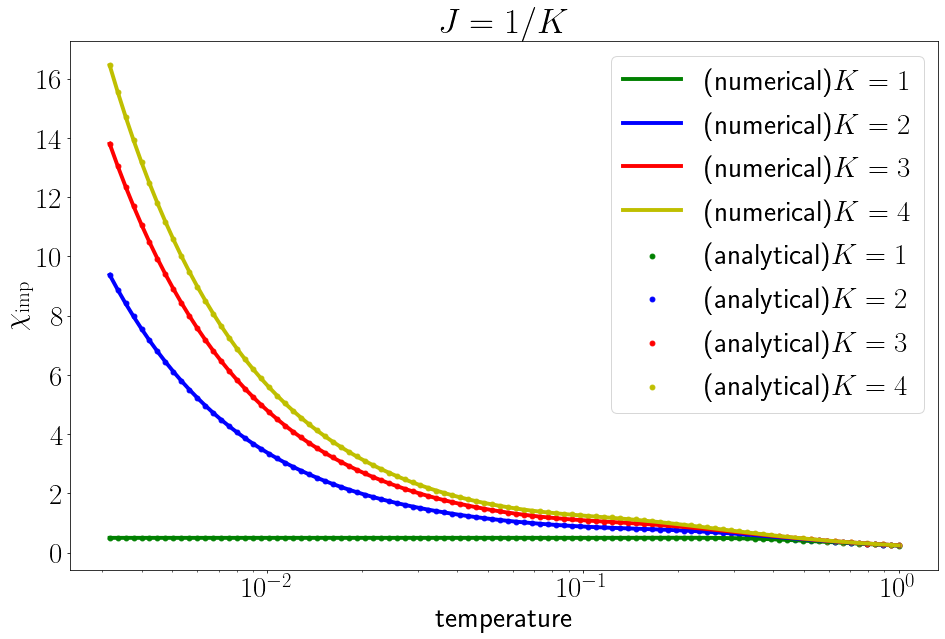

In [189]:
T_range = 10**np.linspace(-2.5, 0, 100)
K = 4
J = 1
cols = ['r', 'b', 'g', 'y']
for K in range(1,5):
    cols = [cols[-1]] + cols[:-1]
    J = 1/K
    chi_ex = get_chi_exact(J,K,T_range)
    chi_num = get_chi_num(J,K,T_range)
    plt.scatter(T_range, chi_ex, marker='.', color=cols[-1], label=r"(analytical)$K={}$".format(K))
    plt.plot(T_range, chi_num, color=cols[-1], label=r"(numerical)$K={}$".format(K))

plt.title(r"$J = 1/K$")
plt.xscale("log")
plt.ylabel("$\chi_\mathrm{imp}$")
plt.xlabel(r"temperature")
plt.legend()
plt.savefig("chi_mchannel.pdf", bbox_inches='tight')
plt.show()

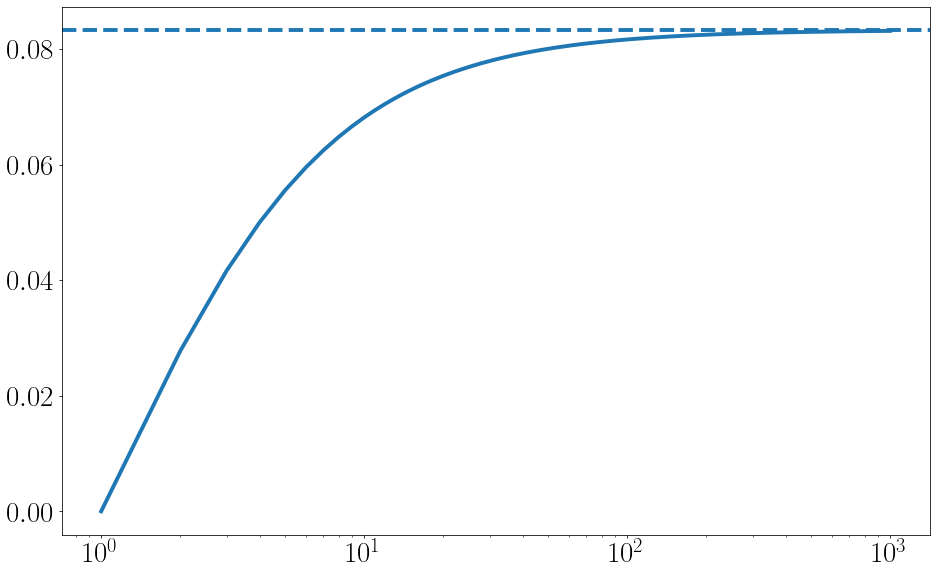

In [190]:
K_range = np.int64(10**np.linspace(0,3,1000))
Sigma_max = np.array([np.sum((np.arange(-K/2, K/2-1+0.1) + 1/2)**2) for K in K_range])
plt.plot(K_range, Sigma_max/(K_range*(K_range+1)**2))
plt.axhline(1/12,0,1, ls="--")
plt.xscale("log")